In [1]:
# Import necessary libraries
import time
import string
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras import backend as K

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
# Read the English to Spanish datafile into a pandas dataframe
# Use columns [0,1] with tab as the seperator, no head
# Set the names of the columns as "English" and "Spanish"
data = pd.read_csv('spa.txt', sep='\t', header=None, usecols=[0,1], names=['English', 'Spanish'])

In [3]:
# Take a quick look at the dataframe
data.head()

,English,Spanish
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


In [4]:
# Subset data to just the first 10000 rows so that we train on Ed
data = data[:10000]
print("Shape:",data.shape)

Shape: (10000, 2)


In [21]:
# For each English and Spanish sentence in the dataframe 
# add the start <s> and end </s> tokens
data.Spanish = '<s> '+data.Spanish+' </s>'

In [10]:
vocab_size = 5000
sequence_length = 8 #20

# Build a function to clean spanish text
# Convert to lower case
# filter out the special spanish token ¡ and ¿ commonly used in formal spanish
strip_chars = '!"#$%&\'()*+,-.:;=?@[\]^_`{|}~¿¡'
def standardize_text(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

# Create a vectorization object for Spanish
vectorization_spa = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=standardize_text,
)

# Create a vectorization object for English
vectorization_eng = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)


2022-03-31 22:52:09.645091: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-31 22:52:09.645391: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [11]:
# Fit both vectorizations on all the text in the dataframe for each language 
vectorization_eng.adapt(data.English)
vectorization_spa.adapt(data.Spanish)

In [12]:
# Build Data Pipelines using TF Dataset

# Set batch size to 256 and train shuffle buffer size to 5000
batch_size = 256
train_shuffle_buffer_size = 5000

# Write a mapping function to process the input data
# First vectorize both english and spanish.
# Since we are using the decoder to predict the next word, the target language must be processed. 
# The source data and target must be shifted by one position
def process(eng, spa):
    eng = vectorization_eng(eng)
    spa = vectorization_spa(spa)
    return (eng,spa[:, :-1]), spa[:, 1:]

# Create TF Dataset, pass in english and spanish as x,y
train_data = tf.data.Dataset.from_tensor_slices((data.English, data.Spanish))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.batch(batch_size)
train_data = train_data.map(process, num_parallel_calls=AUTOTUNE)
train_data = train_data.prefetch(AUTOTUNE)

print("train_data",train_data)

train_data <PrefetchDataset element_spec=((TensorSpec(shape=(None, 8), dtype=tf.int64, name=None), TensorSpec(shape=(None, 8), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 8), dtype=tf.int64, name=None))>


**Positional Encoding**

<img src="https://storage.googleapis.com/public_colab_images/nlp/positional_encoding.png" width="350">

In [13]:
# Write a function to generate positional encodings

def generate_positional_encoding(max_length, model_size):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / model_size) for j in range(model_size)]
            if pos != 0
            else np.zeros(model_size)
            for pos in range(max_length)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

In [22]:
# Generate postional encodings for sequence length of 60 and embedding dimension of 256
positional_encodings = generate_positional_encoding(60, 256)
print(positional_encodings.shape)

(60, 256)


In [23]:
# Compute the dot product of postion 1 with every other postions
dot_results = []
for idx in range(positional_encodings.shape[0]):
  dot_results.append(np.dot(positional_encodings[1], positional_encodings[idx]))

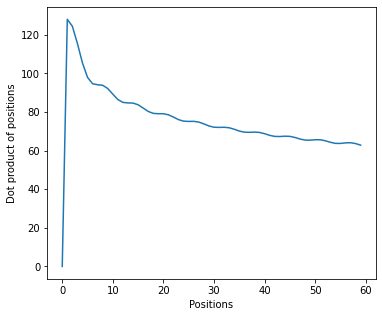

In [24]:
# Plot the dot product results
fig = plt.figure(figsize=(20,5))
axs = fig.add_subplot(1,3,1)
axs.plot(np.arange(0, positional_encodings.shape[0]), dot_results)
axs.set_xlabel('Positions')
axs.set_ylabel('Dot product of positions')
plt.show()

### ⏸ Why do we need to implement positional encoding?
#### A. The transformer encoder needs a way to map token postions to the decoder 
#### B. Positional encoding helps the token embedding add context to them
#### C. A transformer reads in the entire input sequence at once and therefore is order agnositic
#### D. Positional encoding adds noise to input sequence to make back propagation more stable

In [0]:
### edTest(test_chow1) ###
# Submit an answer choice as a string below (eg. if you choose option A, put 'A')
answer1 = 'C'

In [14]:
# Create a Positional Embedding layer that combines
# token embedding with positional encoding
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim):
      super().__init__()

      # Layer parameters
      self.sequence_length = sequence_length
      self.input_dim = input_dim
      self.output_dim = output_dim

      # Token embedding Layer
      self.token_embeddings = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim)

    def call(self, inputs):
      # Generate token embeddings
      embedded_tokens = self.token_embeddings(inputs)
      # Add positional encoding to tge token embedding
      return embedded_tokens + generate_positional_encoding(self.sequence_length,self.output_dim)

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

**Transformer Encoder**

<img src="https://storage.googleapis.com/public_colab_images/nlp/transformer_encoder.png" height="300">

In [15]:
# Create the Transformer Encoder
class Encoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads):
        super().__init__()
        # Layer parameters
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # MultiHeadAttention Layer - Self Attention
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # Normalization Layer
        self.attention_norm = tf.keras.layers.LayerNormalization()

        # Dense projection
        self.dense_proj = tf.keras.Sequential(
            [tf.keras.layers.Dense(units=dense_dim, activation="relu"),
             tf.keras.layers.Dense(units=embed_dim)]
        )
        # Normalization Layer
        self.dense_projection_norm = tf.keras.layers.LayerNormalization()

    def call(self, inputs, mask=None):
        # Apply mask
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        
        # Compute Self Attention
        self_attention = self.attention(query=inputs, value=inputs, key=inputs, attention_mask=mask)
        # Apply Normalization + Residual connection
        self_attention = self.attention_norm(inputs + self_attention)

        # Apply projection
        layer_output = self.dense_proj(self_attention)
        # Apply Normalization + Residual connection
        layer_output = self.dense_projection_norm(self_attention + layer_output)
        return layer_output

### ⏸ Query, Key, Value in a Multi Head Attention layer are used for:
#### A. Lookup tables to find contextual mappings between words
#### B. Training weights
#### C. Transformation functions

In [0]:
### edTest(test_chow2) ###
# Submit an answer choice as a string below (eg. if you choose option A, put 'A')
answer2 = 'B'

**Transformer Decoder**

<img src="https://storage.googleapis.com/public_colab_images/nlp/transformer_decoder.png" height="400">

In [16]:
# Create the Transformer decoder
class Decoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads):
        super().__init__()
        # Layer parameters
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # MultiHeadAttention Layer - Self Attention
        self.attention_1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # Normalization Layer
        self.attention_1_norm = tf.keras.layers.LayerNormalization()

        # MultiHeadAttention Layer - Encoder-Decoder Attention
        self.attention_2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # Normalization Layer
        self.attention_2_norm = tf.keras.layers.LayerNormalization()

        # Dense projection
        self.dense_proj = tf.keras.Sequential(
            [tf.keras.layers.Dense(units=dense_dim, activation="relu"),
             tf.keras.layers.Dense(units=embed_dim)]
        )
        # Normalization Layer
        self.dense_projection_norm = tf.keras.layers.LayerNormalization()

        # Set supports_masking to ensures that the layer will propagate its input mask to its outputs
        self.supports_masking = True

    def get_causal_attention_mask(self, inputs):
        """
        Method that generates a causal mask:
        Since the decoder looks at the entire sequence at once, we need to mask the future
        """
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        # Get Causal Attention Mask
        causal_mask = self.get_causal_attention_mask(inputs)
        # Apply Padding Masks
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        
        # Compute Self Attention
        self_attention = self.attention_1(query=inputs,
                                              value=inputs,
                                              key=inputs,attention_mask=causal_mask)
        # Apply Normalization + Residual connection
        self_attention = self.attention_1_norm(inputs + self_attention)

        # Compute Encoder-Decoder Attention
        encoder_decoder_attention = self.attention_2(query=self_attention,
                                              value=encoder_outputs,
                                              key=encoder_outputs,attention_mask=padding_mask)
        # Apply Normalization + Residual connection
        encoder_decoder_attention = self.attention_2_norm(self_attention + encoder_decoder_attention)

        # Apply projection
        layer_output = self.dense_proj(encoder_decoder_attention)
        # Apply Normalization + Residual connection
        layer_output = self.dense_projection_norm(encoder_decoder_attention + layer_output)
        return layer_output

### ⏸ The second Multi Head Attention layer in the decoder (attention_2):
#### A. Computes the attention score on the decoder inputs with respect to the encoder outputs 
#### B. Computes the self attention scores for the decoder inputs

In [0]:
### edTest(test_chow3) ###
# Submit an answer choice as a string below (eg. if you choose option A, put 'A')
answer3 = 'A'

In [17]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 20
embedding_dim = 128
dense_dim = 512
num_heads = 4

# Free up memory
tf.keras.backend.clear_session()

# Build the model
# Model input
inputs_eng = tf.keras.Input(shape=[None])
inputs_spa = tf.keras.Input(shape=[None])

# Build the Encoder
encoder_ip = PositionalEmbedding(sequence_length, vocab_size, embedding_dim)(inputs_eng)
encoder_op = Encoder(embedding_dim, dense_dim, num_heads)(encoder_ip)

# Build the Decoder
decoder_ip = PositionalEmbedding(sequence_length, vocab_size, embedding_dim)(inputs_spa)
decoder_op = Decoder(embedding_dim, dense_dim, num_heads)(decoder_ip, encoder_op)
decoder_op = tf.keras.layers.Dropout(0.5)(decoder_op)

# Output Layer
output = tf.keras.layers.Dense(units=vocab_size, activation="softmax")(decoder_op)

# Create model
model = tf.keras.Model([inputs_eng, inputs_spa], output)

In [18]:
# Print the model architecture
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, 8, 128)      640000      ['input_1[0][0]']                
 alEmbedding)                                                                                     
                                                                                                  
 positional_embedding_1 (Positi  (None, 8, 128)      640000      ['input_2[0][0]']            

In [25]:
# Optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
# Loss
loss = tf.keras.losses.sparse_categorical_crossentropy

# Compile
model.compile(loss=loss,optimizer=optimizer)

# Train model
start_time = time.time()
print("Training...")
training_results = model.fit(
        train_data,
        epochs=epochs, 
        verbose=0)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Training execution time (mins) 6.545935074488322


In [26]:
spa_vocab = vectorization_spa.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = sequence_length

def decode_sequence(input_sentence):
    tokenized_input_sentence = vectorization_eng([input_sentence])
    decoded_sentence = "<s>"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = vectorization_spa(
            [decoded_sentence])[:, :-1]
        predictions = model(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "</s>":
            break
    return decoded_sentence

for _ in range(10):
    input_sentence = random.choice(data.English)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
Tom drowned.
<s> tomás      a 
-
I'm not married.
<s> no está libre     
-
I'm weak.
<s> estoy borracho      
-
Tom is tidy.
<s> no está en el dinero   
-
You can do it.
<s> que hacerlo      
-
Can I help you?
<s> que te conocen     
-
I drank a lot.
<s> una vez      
-
Let Tom come.
<s> a tom      a
-
Tom is useless.
<s> está tu un ángel    
-
This is OK.
<s> está bien      
